[View in Colaboratory](https://colab.research.google.com/github/webmalex/BuildingMachineLearningSystemsWithPython/blob/master/GDG_codelab_MNIST.ipynb)

# 0 Введение

Скрипя своим тщедушным телом,<br>
Чтобы добыть на ужин снедь,<br>
В предместьях рыбного отдела<br>
Мужик закинул нейросеть.

По мотивам [TensorFlow and depp learning without PhD](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#0)

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/93d5f08a4f82d4c.png" alt="TensorFlow and depp learning without PhD"  width="500"/>

Дополнительно:<br>
[Get Started with TensorFlow](https://www.tensorflow.org/tutorials/) - доки по TF<br>
[TensorBoard Tutorial](https://www.datacamp.com/community/tutorials/tensorboard-tutorial) - годная статья

Ресурсы:
1. Sebastian Raschka, Vahid Mirjalili Python Machine Learning.
2. https://pprc.qmul.ac.uk/~bevan/statistics/TensorFlow.html - INTRODUCTION TO SOME FEATURES OF
TENSOR FLOW TO GET YOU STARTED


В этой работе мы научимся строить и тренировать нейронную сеть, которая распознает рукописные цифры. По мере улучшения точности предсказаний сети заодно познакомимся с инструментами для эффективного обучения моделей.

Будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/) - 60000 размеченных образцов рукописных цифр. Все цифры нормализованы по размеру (28х28)

Что узнаем:
 * Что такое нейронная сеть и как ее обучать
 * Как создать базовую 1-слойную нейронную сеть с использованием TensorFlow
 * Как добавить дополнительные слои
 * Советы по обучению и трюки: переобучение, регуляризация, затухание скорости обучения и т.д.


## 0.1 Проброс TensorBoard
Некая магия, которая заставляет торчать наружу.

### 0.1.1 Первый вариант
Если не сработает, идём в следующий

In [1]:
LOG_DIR = 'summaries'
get_ipython().system_raw('tensorboard --logdir={} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
!unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://4731324f.ngrok.io


### 0.1.2 Второй вариант
Если не сработает - уже ничего не поможет

In [21]:
#LOG_DIR = 'summaries'
#get_ipython().system_raw('tensorboard --logdir={} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

# Install
!npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.1
added 54 packages from 31 contributors in 3.3s


In [22]:

# Get url
!cat url.txt

your url is: https://empty-squid-5.localtunnel.me


## 0.2 Загрузка данных

In [2]:
#здесь классик для загрузки MNIST для автономной работы
!git clone https://github.com/ixomaxip/codelab.git

Cloning into 'codelab'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [0]:
import tensorflow as tf
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from codelab.mnist_loader import read_data_sets

Загрузим данные и посмотрим, что получили:

In [4]:
mnist = read_data_sets("MNIST_data", one_hot=True, reshape=True)

Successfully downloaded and unzipped train-images-idx3-ubyte.gz 9912422 bytes.
Successfully downloaded and unzipped train-labels-idx1-ubyte.gz 28881 bytes.
Successfully downloaded and unzipped t10k-images-idx3-ubyte.gz 1648877 bytes.
Successfully downloaded and unzipped t10k-labels-idx1-ubyte.gz 4542 bytes.


In [5]:
print('Train images shape:\t', mnist.train.images.shape)
print('Test images shape:\t', mnist.test.images.shape)

Train images shape:	 (60000, 784)
Test images shape:	 (10000, 784)


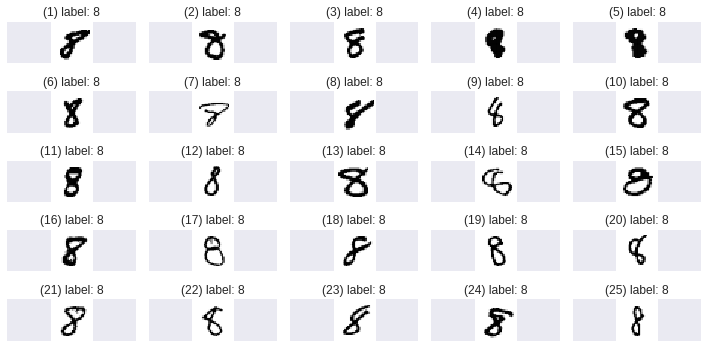

In [7]:
flt = np.argmax(mnist.train.labels, axis=1) == 8

X_train = mnist.train.images[flt][:25]
lab = mnist.train.labels[flt][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()

for i in range(25):
    img = X_train[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('({}) label: {}'.format(i+1, lab[i].argmax()))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()    

## 0.3 Общие принципы TensorFlow:
1. Создаём пустой граф
2. Добавляеем узлы (тензоры и операции над ними) в граф
3. Выолняем граф:
    1. Запускаем сессию
    2. Инициализируем переменные в графе
    3. Запускаем вычислительный граф в этой сессии

# 1. Однослойная сеть

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/d5222c6e3d15770a.png" alt="
 · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]        # 784 = 28 * 28
 \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
   · · · · · · · ·                                              Y [batch, 10]
 "  width="500"/>

 Сначала определим переменные и метапеременные.
 - Переменные - все те параметры, котрые мы планируем обучать в процессе выполнения алгоритма - веса и смещения.
 - Метапеременные - параметры, которые будут заполнены конкретными данными во время обучения - входные данные.


In [0]:
image_size = 28
n_classes = 10

tf.reset_default_graph()
tf.set_random_seed(0)

#мета для входных картинок
X = tf.placeholder(tf.float32, [None, image_size*image_size], name='train_inputs')
# мета для правильных ответов
Y_ = tf.placeholder(tf.float32, [None, 10], name='train_labels')

Форма тензоров для метапеременных определяется размером картинок 28х28 для X и количеством классов (цифры от 0 до 9) для Y. None - эта размерность указывает на количество образцов в пакете данных.

## 1.1 Модель

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/21dabcf6d44e4d6f.png" alt="drawing" width="500"/>

In [0]:
#картинка с нейроном
with tf.name_scope('out'):
    with tf.name_scope('weights'):
        weights = tf.Variable(tf.zeros([image_size*image_size, n_classes]))
    with tf.name_scope('biases'):
        biases = tf.Variable(tf.zeros([n_classes]))
    with tf.name_scope('xw_plus_b'):
        Y = tf.nn.softmax(tf.matmul(X, weights) + biases)

Сначала задаём веса и смещения. Далее, суммируем с весами 28*28 входных нейронов, добавляем смещения и складываем в переменную - это предсказания сети:

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/604a9797da2a48d7.png" alt="softmax" width="250"/>

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/206327168bc85294.png" alt="softmax" width="400"/>


## 1.2 Функция потерь

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/1d8fc59e6a674f1c.png" alt="drawing" width="400"/>

In [0]:
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y))

Теперь, когда мы знаем предсказания, нужно понять - насколько они хороши? Надо как-то измерить расстояние между правильными и предсказанными ответами. В качестве расстояния возьмём кросс-энтропию.



## 1.3 Оптимизатор

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/34e9e76c7715b719.png" alt="drawing" width="600"/>

In [0]:
learning_rate = 0.003
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

Полученную метрику и будем минимизировать. Для этого используем стандартный градиентный спуск. Темп обучения задаёт шаг вдоль вектора градиента. Чтобы не перескочить минимум, берём маленький шаг.

## 1.4 Отчёты для TensorBoard

Чтобы получить графики для процесса обучения и результаты проверки на тестовых данных, создаём различные виды отчётов - summary. Те показатели, которые мы укажем сериализуюстся в процессе выполнения сессии и TensorBoard сможет их считать.

In [0]:
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Y_, axis=1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

merged = tf.summary.merge_all()

## 1.5 Запускаем сеть

In [0]:
def get_summary_path(sub_folder):
    import os
    summ_folder =  LOG_DIR#'summaries'
    
    summary_path = os.path.join(summ_folder, sub_folder)
    if not os.path.exists(summ_folder):
        os.mkdir(summ_folder)
    if not os.path.exists(summary_path):
        os.mkdir(summary_path)
        
    return summary_path

Всё, что мы до этого момента делали - лишь конструктор графа. Ничего на расчёт не запускалось. Время проверить, всё ли правильно было сделано.

Первым делом надо объявить сессию!

Задаём объекты для сериализации - отдельно для обучения, отдельно для теста.

В цикле с помощью train_step, который минимизирует кросс-энтропию, обновляются веса и смещения и каждые 10 шагов замеряем точность на тестовых данных. Только замеряем!

In [14]:
batch_size = 100
max_step = 2001

session = tf.InteractiveSession()

summary_path = get_summary_path('nn_1l')

train_writer = tf.summary.FileWriter(summary_path + '/train', session.graph)
test_writer = tf.summary.FileWriter(summary_path + '/test')

tf.global_variables_initializer().run()

for i in range(max_step):
    if i % 10 == 0:
        xs, ys = mnist.test.images, mnist.test.labels
        summary, acc = session.run([merged, accuracy], feed_dict={X: xs, Y_: ys})
        test_writer.add_summary(summary, i)
        if i % 100 == 0:
            print('Accuracy at step %s: %s' % (i, acc))
    else:
        xs, ys = mnist.train.next_batch(batch_size)
        summary, _ = session.run([merged, train_step], feed_dict={X: xs, Y_: ys})
        train_writer.add_summary(summary, i)

session.close()

Accuracy at step 0: 0.098
Accuracy at step 100: 0.8863
Accuracy at step 200: 0.9013
Accuracy at step 300: 0.9054
Accuracy at step 400: 0.9071
Accuracy at step 500: 0.9074
Accuracy at step 600: 0.9109
Accuracy at step 700: 0.9118
Accuracy at step 800: 0.9153
Accuracy at step 900: 0.9147
Accuracy at step 1000: 0.9147
Accuracy at step 1100: 0.9143
Accuracy at step 1200: 0.917
Accuracy at step 1300: 0.9177
Accuracy at step 1400: 0.9159
Accuracy at step 1500: 0.9194
Accuracy at step 1600: 0.9211
Accuracy at step 1700: 0.9203
Accuracy at step 1800: 0.9206
Accuracy at step 1900: 0.9215
Accuracy at step 2000: 0.9212


# 2. Добавим слои
Чтобы улучшить распознавательную способность сети, нам понадобится добавить скрытые слои.

Дополнительно, некоторые вещи спихнём в функции, что заметно облегчит жизнь при модификации сети.

В качестве функций активации будем использовать классическую сигмоиду:

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/77bc41f211c9fb29.png" alt="drawing" width="500"/>

In [0]:
image_size = 28
n_classes = 10

tf.reset_default_graph() #сбросим граф

#мета для входных картинок
X = tf.placeholder(tf.float32, [None, image_size*image_size], name='train_inputs')
# мета для правильных ответов
Y_ = tf.placeholder(tf.float32, [None, 10], name='train_labels')

In [0]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

def nn_layer(input_tensor, input_dim, output_dim, layer_name, activation):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            initial = tf.truncated_normal([input_dim, output_dim], stddev=0.1)
            weights = tf.Variable(initial)
            variable_summaries(weights)
        with tf.name_scope('biases'):
            initial = tf.truncated_normal([output_dim], stddev=0.1)
            biases = tf.Variable(initial)
            variable_summaries(biases)
        with tf.name_scope('xw_plus_b'):
            preactivate = tf.nn.xw_plus_b(input_tensor, weights, biases)
        activations = activation(preactivate, name='activation')
        
        return activations 

In [0]:
hidden1 = nn_layer(X, image_size*image_size, 200, 'hidden1', tf.nn.sigmoid)
hidden2 = nn_layer(hidden1, 200, 100, 'hidden2', tf.nn.sigmoid)
hidden3 = nn_layer(hidden2, 100, 60, 'hidden3', tf.nn.sigmoid)
hidden4 = nn_layer(hidden3, 60, 30, 'hidden4', tf.nn.sigmoid)

Y = nn_layer(hidden4, 30, n_classes, 'out', tf.nn.softmax)

В качестве функций активации будем использовать классическую сигмоиду:

<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/e5d46c389470df62.png" alt="drawing" width="300"/>

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
# функция потерь
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y))

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
# Optimizer
learning_rate = 0.003
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Y_, axis=1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged = tf.summary.merge_all()

In [15]:
max_step=2001
batch_size=100

session = tf.InteractiveSession()

summary_path = get_summary_path('nn_4hid')

train_writer = tf.summary.FileWriter(summary_path + '/train', session.graph)
test_writer = tf.summary.FileWriter(summary_path + '/test')

tf.global_variables_initializer().run()

for i in range(max_step):
    if i % 10 == 0:
        xs, ys = mnist.test.images, mnist.test.labels
        summary, acc = session.run([merged, accuracy], feed_dict={X: xs, Y_: ys})
        test_writer.add_summary(summary, i)
        if i % 100 == 0:
            print('Accuracy at step %s: %s' % (i, acc))
    else:
        xs, ys = mnist.train.next_batch(batch_size)
        summary, _ = session.run([merged, train_step], feed_dict={X: xs, Y_: ys})
        train_writer.add_summary(summary, i)

session.close()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Accuracy at step 0: 0.098
Accuracy at step 100: 0.1032
Accuracy at step 200: 0.1032
Accuracy at step 300: 0.1135
Accuracy at step 400: 0.1937
Accuracy at step 500: 0.1135
Accuracy at step 600: 0.1135
Accuracy at step 700: 0.1135
Accuracy at step 800: 0.098
Accuracy at step 900: 0.1439
Accuracy at step 1000: 0.1135
Accuracy at step 1100: 0.1135
Accuracy at step 1200: 0.0958
Accuracy at step 1300: 0.1135
Accuracy at step 1400: 0.0974
Accuracy at step 1500: 0.1032
Accuracy at step 1600: 0.1028
Accuracy at step 1700: 0.0958
Accuracy at step 1800: 0.1966
Accuracy at step 1900: 0.2674
Accuracy at step 2000: 0.2894


### упс! точность стала только хуже

# 3. Особенности глубоких сетей

### 3.1 Поменяем сигмоиду на RuLU

Сигмоида, конечно, хорошая, но даёт плохие результаты в глубоком обучении. Это связано с тем, что она всю числовую ось сжимает в отрезок от 0 до 1ю Следовательно, при достаточно большом абсолютном значении входа, она будет выдавать всегда что-то близкое к 0 или к 1, и часть нейронов просто обнулится.

В современных сетях часто используют ReLU:<br>
<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/60cac06459b3cc08.png" alt="drawing" width="300"/>

In [0]:
image_size = 28
n_classes = 10

tf.reset_default_graph() #сбросим граф

#мета для входных картинок
X = tf.placeholder(tf.float32, [None, image_size*image_size], name='train_inputs')
# мета для правильных ответов
Y_ = tf.placeholder(tf.float32, [None, 10], name='train_labels')

In [0]:
hidden1 = nn_layer(X, image_size*image_size, 200, 'hidden1', tf.nn.relu)
hidden2 = nn_layer(hidden1, 200, 100, 'hidden2', tf.nn.relu)
hidden3 = nn_layer(hidden2, 100, 60, 'hidden3', tf.nn.relu)
hidden4 = nn_layer(hidden3, 60, 30, 'hidden4', tf.nn.relu)

Y = nn_layer(hidden4, 30, n_classes, 'out', tf.nn.softmax)

МЕНЯЕМ ТУТ

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
# функция потерь
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y))
        
#БЕЗ ИЗМЕНЕНИЙ
# Optimizer
learning_rate = 0.003
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Y_, axis=1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged = tf.summary.merge_all()

In [20]:
max_step=2001
batch_size=100

session = tf.InteractiveSession()

summary_path = get_summary_path('nn_4hid_ReLU')

train_writer = tf.summary.FileWriter(summary_path + '/train', session.graph)
test_writer = tf.summary.FileWriter(summary_path + '/test')

tf.global_variables_initializer().run()

for i in range(max_step):
    if i % 10 == 0:
        xs, ys = mnist.test.images, mnist.test.labels
        summary, acc = session.run([merged, accuracy], feed_dict={X: xs, Y_: ys})
        test_writer.add_summary(summary, i)
        if i % 100 == 0:
            print('Accuracy at step %s: %s' % (i, acc))
    else:
        xs, ys = mnist.train.next_batch(batch_size)
        summary, _ = session.run([merged, train_step], feed_dict={X: xs, Y_: ys})
        train_writer.add_summary(summary, i)

session.close()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Accuracy at step 0: 0.0987
Accuracy at step 100: 0.8521
Accuracy at step 200: 0.9075
Accuracy at step 300: 0.9312
Accuracy at step 400: 0.9408
Accuracy at step 500: 0.9192
Accuracy at step 600: 0.943
Accuracy at step 700: 0.952
Accuracy at step 800: 0.9442
Accuracy at step 900: 0.9625
Accuracy at step 1000: 0.951
Accuracy at step 1100: 0.953
Accuracy at step 1200: 0.9655
Accuracy at step 1300: 0.9686
Accuracy at step 1400: 0.9575
Accuracy at step 1500: 0.966
Accuracy at step 1600: 0.9709
Accuracy at step 1700: 0.9557
Accuracy at step 1800: 0.9605
Accuracy at step 1900: 0.9667
Accuracy at step 2000: 0.9664


### 3.2 Сменим оптимизатор

В многомерных пространствах, как наше, частое явление - седловые точки - они не я вляются минимумами, но в них градиент равен 0. Поэтому градиентный спуск может в них засесть и дальше не двигаться. Поэтому заменим его на другой метод.

In [0]:
image_size = 28
n_classes = 10

tf.reset_default_graph() #сбросим граф

#мета для входных картинок
X = tf.placeholder(tf.float32, [None, image_size*image_size], name='train_inputs')
# мета для правильных ответов
Y_ = tf.placeholder(tf.float32, [None, 10], name='train_labels')

In [0]:
hidden1 = nn_layer(X, image_size*image_size, 200, 'hidden1', tf.nn.relu)
hidden2 = nn_layer(hidden1, 200, 100, 'hidden2', tf.nn.relu)
hidden3 = nn_layer(hidden2, 100, 60, 'hidden3', tf.nn.relu)
hidden4 = nn_layer(hidden3, 60, 30, 'hidden4', tf.nn.relu)

Y = nn_layer(hidden4, 30, n_classes, 'out', tf.nn.softmax)

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
# функция потерь
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y))
        #cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=Y_, logits=Y)
        
# Optimizer
learning_rate = 0.003
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate) #<-------------------
    train_step = optimizer.minimize(cross_entropy)

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Y_, axis=1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged = tf.summary.merge_all()

In [0]:
max_step=2001
batch_size=100

session = tf.InteractiveSession()

summary_path = get_summary_path('nn_4hid_ReLU_Adam')

train_writer = tf.summary.FileWriter(summary_path + '/train', session.graph)
test_writer = tf.summary.FileWriter(summary_path + '/test')

tf.global_variables_initializer().run()

for i in range(max_step):
    if i % 10 == 0:
        xs, ys = mnist.test.images, mnist.test.labels
        summary, acc = session.run([merged, accuracy], feed_dict={X: xs, Y_: ys})
        test_writer.add_summary(summary, i)
        if i % 100 == 0:
            print('Accuracy at step %s: %s' % (i, acc))
    else:
        xs, ys = mnist.train.next_batch(batch_size)
        summary, _ = session.run([merged, train_step], feed_dict={X: xs, Y_: ys})
        train_writer.add_summary(summary, i)

session.close()

# 4. Затухание темпа обучения

Мы уже получаем довольно хорошую точность - 96%!

Кривые зашумлены, скорее всего это означает что мы идём слишком большим шагом. Но мы не можем просто так его уменьшить, в этом случае обучение будет слишком долгим. Самое лучшее что можно сделать - начать с большого шага и постепенно его уменьшать.

In [0]:
image_size = 28
n_classes = 10

tf.reset_default_graph() #сбросим граф

#мета для входных картинок
X = tf.placeholder(tf.float32, [None, image_size*image_size], name='train_inputs')
# мета для правильных ответов
Y_ = tf.placeholder(tf.float32, [None, 10], name='train_labels')

hidden1 = nn_layer(X, image_size*image_size, 200, 'hidden1', tf.nn.relu)
hidden2 = nn_layer(hidden1, 200, 100, 'hidden2', tf.nn.relu)
hidden3 = nn_layer(hidden2, 100, 60, 'hidden3', tf.nn.relu)
hidden4 = nn_layer(hidden3, 60, 30, 'hidden4', tf.nn.relu)

Y = nn_layer(hidden4, 30, n_classes, 'out', tf.identity)

#БЕЗ ИЗМЕНЕНИЙ
# функция потерь
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        #ТУТ НАДО ЗАМЕНИТЬ НА БИБЛИОТЕЧНУЮ. т.к. она корректно обрабатывает NaN.
        #При этом, нужно будет на последнем слое softmax убрать
        #cross_entropy = - tf.reduce_sum(Y_ * tf.log(Y)) 
        cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=Y_, logits=Y)

In [0]:
step = tf.placeholder(tf.int32)
learning_rate = 0.0001 + tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)

Чтобы уемньшать шаг в зависимости от итерации, нужно задать placeholder для передачи номера итерации во время вычисления графа. На основе этого шага и сформируем экспоненциально затухающий темп.

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Y_, axis=1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged = tf.summary.merge_all()

In [20]:
max_step=10000
batch_size=100

session = tf.InteractiveSession()

summary_path = get_summary_path('nn_4hid_ReLU_Adam_lrdecay')

train_writer = tf.summary.FileWriter(summary_path + '/train', session.graph)
test_writer = tf.summary.FileWriter(summary_path + '/test')

tf.global_variables_initializer().run()

for i in range(max_step):
    if i % 10 == 0:
        xs, ys = mnist.test.images, mnist.test.labels
        summary, acc = session.run([merged, accuracy], feed_dict={X: xs, Y_: ys})
        test_writer.add_summary(summary, i)
        if i % 100 == 0:
            print('Accuracy at step %s: %s' % (i, acc))
    else:
        xs, ys = mnist.train.next_batch(batch_size)
        summary, _ = session.run([merged, train_step], feed_dict={X: xs, Y_: ys, step: i}) # <-----------step: i---------------
        train_writer.add_summary(summary, i)

session.close()

Accuracy at step 0: 0.0912
Accuracy at step 100: 0.888
Accuracy at step 200: 0.9331
Accuracy at step 300: 0.95
Accuracy at step 400: 0.9535
Accuracy at step 500: 0.9545
Accuracy at step 600: 0.961
Accuracy at step 700: 0.9549
Accuracy at step 800: 0.9693
Accuracy at step 900: 0.9672
Accuracy at step 1000: 0.9687
Accuracy at step 1100: 0.9674
Accuracy at step 1200: 0.9678
Accuracy at step 1300: 0.9682
Accuracy at step 1400: 0.973
Accuracy at step 1500: 0.9739
Accuracy at step 1600: 0.9752
Accuracy at step 1700: 0.9745
Accuracy at step 1800: 0.9732
Accuracy at step 1900: 0.9738
Accuracy at step 2000: 0.976
Accuracy at step 2100: 0.9738
Accuracy at step 2200: 0.9769
Accuracy at step 2300: 0.975
Accuracy at step 2400: 0.9766
Accuracy at step 2500: 0.9745
Accuracy at step 2600: 0.9758
Accuracy at step 2700: 0.9774
Accuracy at step 2800: 0.9777
Accuracy at step 2900: 0.9764
Accuracy at step 3000: 0.9753
Accuracy at step 3100: 0.9754
Accuracy at step 3200: 0.9748
Accuracy at step 3300: 0.9751

Т.к. ввели новую метапеременную (step), нужно передавать её при выполнении сессии

# Прореживание

В какой-то момент на больших итерациях тестовая кросс-энтропия начинает расти - дальше её уже ничто не остановит. Это переобучение. Ведь алгоритм настраивается только на кросс-энтропию обучающих данных.  Просто наша сеть смогла запомнить почти все образцы обучающей выборки и потеряла обобщающую способность.

В этом случае мы можем попробовать прореживание, или dropuot - один из видов регуляризации:<br>
<img src="https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/5ee25552f4c216c.png" width=400/>

In [0]:
image_size = 28
n_classes = 10

tf.reset_default_graph()

#мета для входных картинок
X = tf.placeholder(tf.float32, [None, image_size*image_size], name='train_inputs')
# мета для правильных ответов
Y_ = tf.placeholder(tf.float32, [None, 10], name='train_labels')

In [0]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

def nn_layer(input_tensor, input_dim, output_dim, layer_name, activation):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            initial = tf.truncated_normal([input_dim, output_dim], stddev=0.1)
            weights = tf.Variable(initial)
            variable_summaries(weights)
        with tf.name_scope('biases'):
            initial = tf.truncated_normal([output_dim], stddev=0.1)
            biases = tf.Variable(initial)
            variable_summaries(biases)
        with tf.name_scope('xw_plus_b'):
            preactivate = tf.nn.xw_plus_b(input_tensor, weights, biases)
        activations = activation(preactivate, name='activation')
        
        return activations 

In [0]:
pkeep = tf.placeholder(tf.float32)

hidden1 = nn_layer(X, image_size*image_size, 200, 'hidden1', tf.nn.relu)
hidden1_d = tf.nn.dropout(hidden1, pkeep)

hidden2 = nn_layer(hidden1_d, 200, 100, 'hidden2', tf.nn.relu)
hidden2_d = tf.nn.dropout(hidden2, pkeep)

hidden3 = nn_layer(hidden2_d, 100, 60, 'hidden3', tf.nn.relu)
hidden3_d = tf.nn.dropout(hidden3, pkeep)

hidden4 = nn_layer(hidden3_d, 60, 30, 'hidden4', tf.nn.relu)
hidden4_d = tf.nn.dropout(hidden4, pkeep)

Y = nn_layer(hidden4_d, 30, n_classes, 'out', tf.identity)

Дропаут заключается в том, что на каждой итерации обучения некоторые нейроны полностью выбрасываются из сети. Какие именно нейроны это будут, определяется параметром pkeep, который задаёт вероятность того, что нейрон останестя. При работе с тестовыми данными уже нельзя выкидывать нейроны - сеть обучена - и поэтому параметр выставляется в 1.

In [0]:
#БЕЗ ИЗМЕНЕНИЙ
# функция потерь
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=Y_, logits=Y)
        
step = step = tf.placeholder(tf.int32)
learning_rate = 0.0001 + tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)
    
#БЕЗ ИЗМЕНЕНИЙ
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Y_, axis=1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged = tf.summary.merge_all()

In [0]:
max_step=10000
batch_size=100

session = tf.InteractiveSession()

summary_path = get_summary_path('nn_4hid_ReLU_Adam_lrdecay_dp')

train_writer = tf.summary.FileWriter(summary_path + '/train', session.graph)
test_writer = tf.summary.FileWriter(summary_path + '/test')

tf.global_variables_initializer().run()

for i in range(max_step):
    if i % 10 == 0:
        xs, ys = mnist.test.images, mnist.test.labels
        summary, acc = session.run([merged, accuracy], feed_dict={X: xs, Y_: ys, pkeep: 1.0}) #<----------pkeep: 1.0--------------
        test_writer.add_summary(summary, i)
        if i % 100 == 0:
            print('Accuracy at step %s: %s' % (i, acc))
    else:
        xs, ys = mnist.train.next_batch(batch_size)
        summary, _ = session.run([merged, train_step], feed_dict={X: xs, Y_: ys, step: i, pkeep: 0.75}) #<----------pkeep: 0.75-------------
        train_writer.add_summary(summary, i)

session.close()

Опять ввели новую метапеременную - нужно передать её значение, т.к. мы обещали графу, что на момент вычислений там что-нибудь окажется